## Overview

Image classification refers to the task of assignin an input image one label from a fixed set of categories. This is one of the core problems in Computer Vision that, despite its simplicity, has a large variety of practical applications.

In this post we will learn how one of the most influential innovations in the field of computer vision (**Convolutional Neural Network**) can "understand" a natural image well-enough to solve **image classification** problem.

We will build an image classifiers from scratch, starting from JPEG images files on disk, without leveraging pre-trained weights or a pre-made keras application model, you can find all the code in my [Github Repository]()


## The Convolutional Classifier

A Convolutional Network used for image classification has two parts: a **convolutional base** and a **dense head**.

![The Convolutional Classifier.](https://edinsonjim.idesoft.co/articles/image-classifier-using-tensorflow-and-keras/images/2021-08-19-13-41-39.png)


The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well.

> **feature** could be a line, a color, a texture, a shape, a pattern or some complicated combination.

The head is used to **determinate the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout.

![Example of the whole process.](https://edinsonjim.idesoft.co/articles/image-classifier-using-tensorflow-and-keras/images/2021-08-19-19-15-46.png)

## Setup and Data preparation

### Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Download the data

We are using a custom dataset created for this post to classificate **Identification Cards**, we will clone the dataset repository that contains 3 sub-directories inside `training` folder, one per class.


In [3]:
!git clone https://github.com/edinsonjim/ids-dataset.git

Cloning into 'ids-dataset'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 0), reused 39 (delta 0), pack-reused 0
Unpacking objects: 100% (39/39), done.


```bash
ids-dataset
├── readme.md
├── test
│   ├── 0001.jpeg
│   ├── 0002.jpg
│   ├── 0003.jpg
│   ├── 0004.jpg
│   └── 0005.png
└── training
    ├── italy
    │   ├── 0000.jpg
    │   ├── 0001.jpg
    │   ├── 0003.jpg
    │   ├── 0004.jpg
    │   ├── 0005.jpg
    │   ├── 0006.jpg
    │   ├── 0007.jpg
    │   └── 0008.jpg
    ├── peru
    │   ├── 0001.jpg
    │   ├── 0002.jpg
    │   ├── 0003.jpg
    │   ├── 0004.jpg
    │   ├── 0005.jpg
    │   ├── 0006.jpg
    │   ├── 0007.jpg
    │   ├── 0008.jpg
    │   ├── 0009.jpg
    │   ├── 0010.jpg
    │   └── 0011.jpg
    └── spain
        ├── 0001.jpg
        ├── 0002.jpg
        ├── 0003.jpg
        ├── 0004.jpg
        ├── 0005.jpg
        └── 0006.jpg
```

### Generate a dataset

After clone the repository, we can load the dataset using the helpful `image_dataset_from_directory` utility and create our training and validation dataset.

Let's define some parameters for the loader.

In [4]:
WORK_DIR = "./ids-dataset/training"

IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 10


- `WORK_DIR`: Path to training data.
- `IMAGE_SIZE`: Size to resize images to after they are read from disk.
- `BATCH_SIZE`: Number of samples that will be passed through to the network at one time.

#### Training dataset

Machine Learning algorithms require training data to achieve an objective. The algorithm will analyze this training dataset, classify the inputs and outputs. These operations allow the model to learn the relationship between the data.


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    WORK_DIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 25 files belonging to 3 classes.
Using 20 files for training.


#### Validation dataset

A trained algorithm will essentially memorize all of the inputs and outputs in a training dataset, this becomes a problem when it need to consider data from other sources.

Here is where validation data is useful. Validation data provides an initial check that the model can return useful predictions in a real-world setting.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    WORK_DIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 25 files belonging to 3 classes.
Using 5 files for validation.


> It's a good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.


We can find the class names in the `class_names` attribute on these datasets, that correspond to the directory names in alphabetical order.


In [7]:
class_names = train_ds.class_names
print(class_names)

['italy', 'peru', 'spain']


### Visualize the data

Let's visualize the first images in the training dataset.


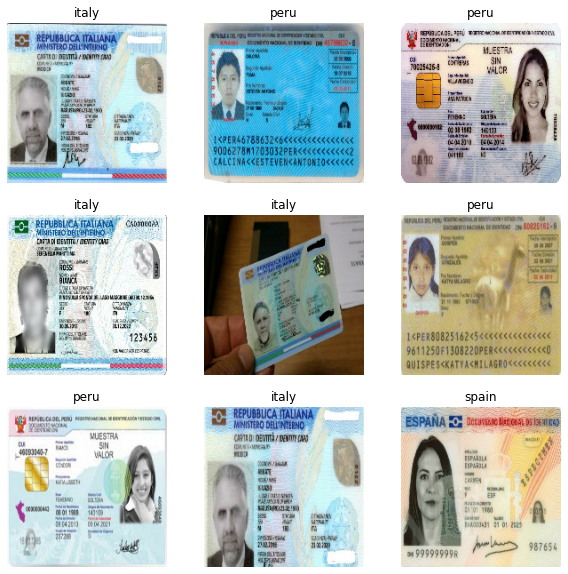

In [8]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first each. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

If you are interested, you can learn more about how to cache data in the [data performance guide](https://www.tensorflow.org/guide/data_performance#optimize_performance).


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.


In [10]:
COLOR_CHANNELS = 3 # 3 channels (RGB)

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal",
                                                  input_shape=(IMAGE_HEIGHT,
                                                               IMAGE_WIDTH,
                                                               COLOR_CHANNELS)),
     layers.experimental.preprocessing.RandomRotation(0.01),
     layers.experimental.preprocessing.RandomZoom(0.01)
    ]
)


- `input_shape`: Initial tensor that we send to the first hidden layer. This tensor should have the same shape as our training data.

Let's visualize what the augmented samples looks like, by applying `data_augmentation` repeatedly to the first images in the dataset.


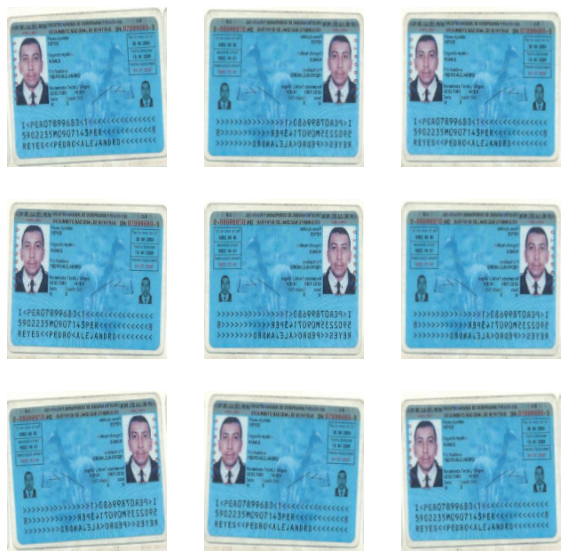

In [11]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Standardizing the data

Our image are already in a standard size `(180x180)`, as they are being yielded as contiguos `float32` batches by our dataset. However, their RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of our model.

In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Build a model

Now we'll define a small model. See how our model consist of six blocks of `Conv2D` and `MaxPool2D` layers(the base) followed by a head of `Dense` layers.



> Notice in this definition how the number of filters doubled block by block: 8, 16, ..., 512. This is a common pattern. Since the `MaxPool2D` layer is reducing the size of the feature maps, we can afford to increase the quantity if we wish.

We have three ways to create Keras models, for this post we use the _Sequential model_, wich is limited to single-input and single-output layer stacks. To know other methods, you can visit [Keras Models API](https://keras.io/api/models/).


In [13]:
num_classes = len(class_names)

model = Sequential([
    # preprocessing
    data_augmentation,
    normalization_layer,

    # first convolutional block
    layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),

    # second convolutional block
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),

    # third convolutional block
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),

    # fourth convolutional block
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),

    # fifth convolutional block
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),

    # sixth convolutional block
    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.2), # apply 20% dropout to the next layer to provent overfitting

    # classifier Head
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=num_classes)
])

Note that:

- We start the model with the `data_augmentation` preprocesor, followed by a `normalization` layer previously detailed.
- We include a `Dropout` layer before the final classification layer, used to simulate different network architectures by randomly removing nodes during training, helping to prevent overfitting.


## Compile the model

Choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.


In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

- `optimizers.Adam`: Is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. Used to perform optimization and is one of the best optimizer at preset. [You can read this paper for more details](https://arxiv.org/abs/1412.6980v8).
- `losses.SparseCategoricalCrossentropy`: Use this function when there are two or more label classes. We expect labels to be provided as integers.


## Model summary

If you want to view all the layers of the network, you can use the model's `summary` method.


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)       

## Train the model

In [16]:
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/50
2/2 [==============================] - 2s 554ms/step - loss: 1.0904 - accuracy: 0.4000 - val_loss: 1.1747 - val_accuracy: 0.4000
Epoch 2/50
2/2 [==============================] - 1s 357ms/step - loss: 1.0506 - accuracy: 0.4500 - val_loss: 1.2729 - val_accuracy: 0.4000
Epoch 3/50
2/2 [==============================] - 1s 358ms/step - loss: 0.9984 - accuracy: 0.4500 - val_loss: 1.1347 - val_accuracy: 0.4000
Epoch 4/50
2/2 [==============================] - 1s 371ms/step - loss: 0.9086 - accuracy: 0.4500 - val_loss: 1.0138 - val_accuracy: 0.4000
Epoch 5/50
2/2 [==============================] - 1s 378ms/step - loss: 0.8154 - accuracy: 0.5500 - val_loss: 0.9392 - val_accuracy: 0.4000
Epoch 6/50
2/2 [==============================] - 1s 357ms/step - loss: 0.6987 - accuracy: 0.6500 - val_loss: 1.1374 - val_accuracy: 0.4000
Epoch 7/50
2/2 [==============================] - 1s 376ms/step - loss: 0.6674 - accuracy: 0.6000 - val_loss: 0.8686 - val_accuracy: 0.4000
Epoch 8/50
2/2 [====

> An **epoch** is one pass through an entire dataset. This can be in random order.

## Visualize training results

The keras `fit()` method returns an object containing the training history, including the value of metrics at the end of each epoch.

Let's plot the metrics(loss and accuracy) from the training and validation sets.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Unrecognized location 'lowe right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  app.launch_new_instance()


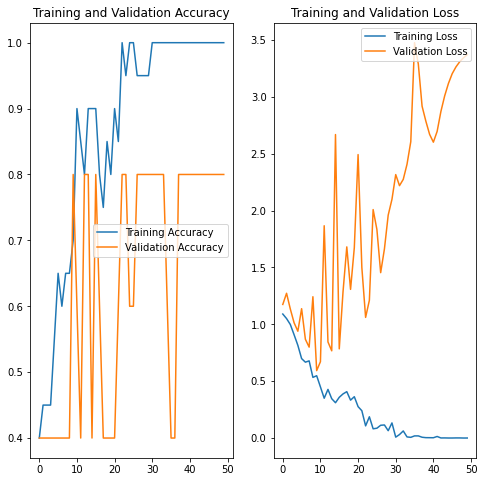

In [17]:
# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot settings for Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lowe right")
plt.title("Training and Validation Accuracy")

# plot settings for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets, but first we create a `show_and_predict` helper method to download, prepare and show the model predictions.

In [18]:
def show_and_predict(img_path):
  """
  Download, prepare and show model predictions
  """
  img = keras.preprocessing.image.load_img(
      img_path, target_size=IMAGE_SIZE
  )

  img_array = keras.preprocessing.image.img_to_array(img)
  img_expanded = tf.expand_dims(img_array, 0) # create a batch

  predictions = model.predict(img_expanded)
  score = tf.nn.softmax(predictions[0])

  plt.imshow(img_array/255)
  plt.axis("off")

  class_name_predicted = class_names[np.argmax(score)]
  score_predicted = 100 * np.max(score)

  print(
      f"This image is most likely a document from {class_name_predicted} with a {score_predicted:.2f} percent confidence."
  )

Now, we can use our helper method and classify new images.

This image is most likely a document from peru with a 50.89 percent confidence.


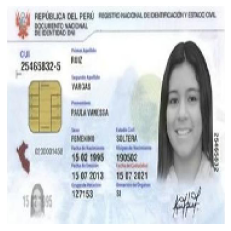

In [19]:
show_and_predict('./ids-dataset/test/0001.jpeg')

This image is most likely a document from italy with a 100.00 percent confidence.


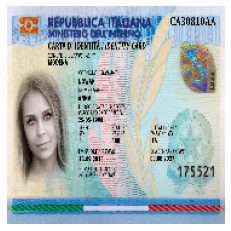

In [20]:
show_and_predict('./ids-dataset/test/0005.png')